In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

# https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

[nltk_data] Downloading package punkt to /home/tychi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tychi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tychi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tychi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/tychi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# supposedly this speeds up the training time
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
np.random.seed(100)

In [4]:
questions_data = pd.read_csv("processed_questions.csv")

In [5]:
questions_data.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count
0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70
1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38


In [6]:
questions_data.shape

(607282, 15)

In [7]:
questions_data['Title'].dropna(inplace=True)
questions_data.shape

(607282, 15)

In [8]:
# convert to lower case
questions_data['Title'] = [title.lower() for title in questions_data['Title']]

In [9]:
# tokenize the words
questions_data['Title'] = [word_tokenize(title) for title in questions_data['Title']]

In [10]:
# Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(questions_data['Title']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    questions_data.loc[index,'Title_final'] = str(Final_words)

In [11]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(questions_data['Title_final'],questions_data['has_positive_answer'],test_size=0.2)

In [12]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [13]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(questions_data['Title_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [14]:
vocab = Tfidf_vect.vocabulary_

### SVM

In [15]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', verbose=True, class_weight="balanced")
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  67.3958684966696


In [16]:
y_pred = (predictions_SVM > 0.5).astype(int) # converts probabilities to predictions (.6 => 1, .4 => 0)

In [17]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Test_Y,  predictions_SVM)
auc = metrics.roc_auc_score(Test_Y, predictions_SVM)

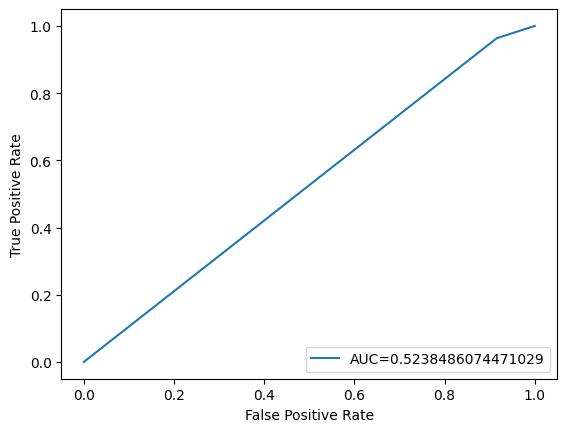

In [18]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(Test_Y, y_pred)

<AxesSubplot:>

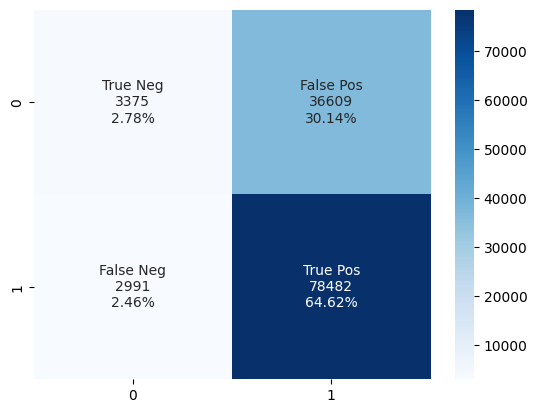

In [20]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(Test_Y, y_pred)
precision = precision_score(Test_Y, y_pred)
recall = recall_score(Test_Y, y_pred)

In [22]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.7985388982723185
precision score is: 0.6819125735287729
recall score is: 0.9632884513888037


In [28]:
questions_data['Title_final']

0         ['find', 'full', 'path', 'font', 'display', 'n...
1               ['get', 'preview', 'jpeg', 'pdf', 'window']
2         ['continuous', 'integration', 'system', 'pytho...
3                              ['iterate', 'result', 'set']
4         ['use', 'match', 'attribute', 'python', 'objec...
                                ...                        
607277    ['execute', 'multiline', 'python', 'code', 'ba...
607278    ['get', 'google', 'recaptcha', 'image', 'sourc...
607279    ['update', 'manytomany', 'field', 'django', 'r...
607280                                 ['possible', 'pair']
607281    ['theano', 'operation', 'return', 'odd', 'resu...
Name: Title_final, Length: 607282, dtype: object

In [30]:
questions_data.head(1)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count,Title_final
0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,"[how, can, i, find, the, full, path, to, a, fo...",<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70,"['find', 'full', 'path', 'font', 'display', 'n..."


In [35]:
Tfidf_vect.get_feature_names_out()

array(['ab', 'abaqus', 'abbreviation', ..., 'zone', 'zoom', 'zope'],
      dtype=object)